Project for the course in Microeconometrics | Summer 2021, M.Sc. Economics, Bonn University | Jonghun Baek

# Replication of Alberto Alesina and Ekaterina Zhuravskaya (2011)
---

The goal of this notebook is to replicate the following paper:

> Alesina, Alberto, and Ekaterina Zhuravskaya. 2011. ["Segregation and the Quality of Government in a Cross Section of Countries."](https://www.aeaweb.org/articles?id=10.1257/aer.101.5.1872) American Economic Review, 101 (5): 1872-1911


* I am providing this pdf file as an advanced essay for the University of Zurich. However, the conversion to a pdf file is not perfect since this file was originally written on Jupyter Notebook. That is why the best option to read this notebook is to download it from my GitHub repository [here](https://github.com/Hun-baek/Project-for-Microeconometrics/blob/main/Replication%20of%20Alesina%20and%20Zhuravskaya%20(2011).ipynb).


* The published original paper, the data, as well as authors' STATA code can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/aer.101.5.1872). 


* The authors' previous version as working paper on NBER does not consider feasible paths between segregation and the quality of government. It is recommended to follow my notebook with the published one on American Economic Review.


* Numbering of tables and figures does not perfectly follow the original. However, the order is kept.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopandas as gpd
import math

from statsmodels.formula.api import ols
from scipy.stats import probplot
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML, Image
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image

from auxiliary.Tables import *
from auxiliary.Plots import *

In [2]:
df = pd.read_stata('data/Segregation_Alesina_Zhuravskaya_x_country.dta')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None

In [3]:
df_E = df[['ethnicity_C2','ethnicity_instrument_C2_thresh','ethnicity_I','lnpopulation','lnGDP_pc',
           'protestants','muslims','catholics','latitude','LOEnglish','LOGerman','LOSocialist','lnArea',
           'LOScandin','democ','mtnall','voice','PolStab','GovEffec','RegQual',
           'ConCorr','RulLaw']].dropna(axis=0)
df_R = df[['religion_C2','religion_instrument_C2_thresh','religion_I','lnpopulation','lnGDP_pc',
           'protestants','muslims','catholics','latitude','LOEnglish','LOGerman','LOSocialist','lnArea',
           'democ','mtnall','RulLaw']].dropna(axis=0)
df_fig = df[['ethnicity_C2','ethnicity_I','language_C2','language_I','religion_C2','religion_I','lnGDP_pc','country'
             ,'ethnicity_C','language_C','religion_C']]
df_w = df[['country','democ']]

---
## Table of contents
---
1. [Introduction](#1.-Introduction)

2. [Indices of fractionalization and segregation](#2.-Indices-of-fractionalization-and-segregation)
    * 2.1. [Fractionalization](#2.1.-Fractionalization)
    * 2.2. [Segregation](#2.2.-Segregation) 
    
3. [Identification](#3.-Identification)

4. [Replication](#4.-Replication)
    * 4.1. [Correlation in segregation](#4.1.-Correlation-in-segregation)
    * 4.2. [Correlation: Segregation and Governance](#4.2.-Correlation:-Segregation-and-Governance)
    * 4.3. [Causal inference](#4.3.-Causal-inference)
        * 4.3.1. [Derivation of instrument ](#4.3.1.-Derivation-of-instrument)
        * 4.3.2. [Results of 2SLS regression](#4.3.2.-Results-of-2SLS-regression)
    * 4.4. [Alternative measures of the quality of government](#4.4.-Alternative-measures-of-the-quality-of-government)
    * 4.5. [Mechanisms](#4.5.-Mechanisms)
    
5. [Extension with critical assessment](#5.-Extension-with-critical-assessment)
    * 5.1. [Missing data and sampling](#5.1.-Missing-data-and-sampling)
    * 5.2. [Multicollinearity test](#5.2.-Multicollinearity-test)
    * 5.3. [Effect size](#5.3.-Effect-size)
    * 5.4. [The role of trust](#5.4.-The-role-of-trust)
    
6. [Conclusion](#6.-Conclusion)

7. [References](#7.-References)

## 1. Introduction
---

Alesina and Zhuravskaya (2011) mention that the pace of development with ethnolinguistic fractionalization has been extensively researched by contemporary economists. Even though many others have stated that fractionalization negatively correlates with policy variables, there obviously are successful countries (e.g. the United States) that are ethnically diverse. Concerning this, it is still questionable which factors precisely influence each country's governmental quality. Segregation is suggested as a key variable to determine the quality of government of a country. The difference between segregation and fractionalization is provided in the first part of chapter 2, indicated by an example from the original paper.

The authors compute the level of segregation and fractionalization on the national and sub-national levels with a new dataset. This paper presents that the higher index level of segregation with respect to ethnicity and language is related to a significantly lower quality of government. The negative correlation between indices of segregation (ethnic and linguistic segregation) and the quality of government particularly come forth in democracies. Moreover, the authors argue that endogeneity exists among the geographical distribution of groups and policy choices since the groups move according to both policies and economic shocks. They resolve this issue by calculating an instrument established on the formation of groups in bordering countries. Finally, they test which path through segregation affects the government quality.

In this notebook, I focus on replicating the main results of this paper and attempt to clearly delineate the procedure. The main purpose is to clarify what exactly creates a difference of governmental quality among a number of countries in the world. Additionally, the expansion part will discuss whether their argument is sufficiently valid or not. Here, there will also be an extensive discussion on multicollinearity, effect size, and sensitivity.

This notebook is composed as following: I first construct the theoretical background to compute indices of segregation that evaluate the level of each country's segregation in chapter 2. Chapter 3 then indicates the identification idea and empirical strategy of authors. In chapter 4, I elaborately replicate and analyze the main results of the paper following the order of the original paper. Finally, after expanding on several ideas in chapter 5, I will conclude this notebook.

## 2. Indices of fractionalization and segregation
---

Alesina and Zhuravskaya (2011) introduce the idea that segregation would be more preferable in establishing governmental quality than fractionalization. Segregation can indicate the situation in each country more precisely. Here is an example to help understand the difference between the two. Suppose that there are two equally sized countries that have the same fractionalization index (1/2) without assuming that there is the geographical distribution of the fractionalized groups. We can then imagine both extremely different circumstances where in one case, one group lives in the northern half of a country and the other group in the southern half. In the other case, all citizens are uniformly distributed throughout the whole country. Both cases have the same fractionalization but the actual situation is entirely different. In the former case, the two geographically separated groups do not share similar social values and, thus, the relationship between them would become more problematic. However, in the latter case, one would expect that two groups are mutually interactive and know each other since they share the same geographical space. This arguably leads to a better quality of government even though they are fractionalized.

### 2.1. Fractionalization
---

The first interest is to calculate the fractionalization level in each country $i$ and for each dimension of diversity, i.e. ethnicity, language, and religion by Herfindahl index. This Herfindal index represents the probability that two randomly selected individuals in a certain nation are affiliated to different groups.<br>
It equals to:
\begin{equation}
    F^{i} = \sum_{m=1}^{M^{i}}\pi_{m}^{i}(1-\pi_{m}^{i})
\end{equation}
where $i$ indicates countries; $m$ stands for groups and $M^{i}$ is the total number of groups in the country $i$. $\pi_{m}^{i}$ is the fraction of group $m$ in the country $i$.


They additionally compute fractionalization indices at the regional level in each country. It contains the same three dimensions of diversity.<br>
The formula is:
\begin{equation}
    F_{j}^{i} = \sum_{m=1}^{M^{i}}\pi_{jm}^{i}(1-\pi_{jm}^{i})
\end{equation}
where $j$ indicates regions and $\pi_{jm}^{i}$ stands for the fraction of group $m$ in region $j$ of country $i$.

With the data sets, the authors conclude that the national fractionalization index is not a trustworthy statistic due to the fact that it can barely explain diversity in countries. Some countries show that the national fractionalization level is not much different from the regional fractionalization level. However, there are also other countries that depict that there is a large difference between the national and regional fractionalization indices.

### 2.2. Segregation
---

On the one hand, a country has a value of 1 if each group occupies a specific region, which means each region is perfectly homogeneous. However, this makes the country fully fractionalized. On the other hand, the segregation index is 0 when each region is structured with the same components. This means that a country is not perfectly segregated.
The authors derive the fundamental index of segregation by referring to Reardon and Firebaugh (2002).<br>
The formula follows:
\begin{equation}
    S^{i} = \frac{1}{M^{i}-1}\sum_{m=1}^{M^{i}}\sum_{j=1}^{J^{i}}\frac{t_{j}^{i}}{T^{i}}\frac{(\pi_{jm}^{i}-\pi_{m}^{i})^2}{\pi_{m}^{i}}
\end{equation}
where $T^{i}$ is the total population of country $i$ and $t_{j}^{i}$ is the population of region $j$ in country $i$. $J^{i}$ is the total number of regions in country $i$. The rest of the notation is as above. $S$ is increasing according to the square deviation of regional level of fractions relative to the national average. The larger difference between the regional fraction and the country's average influence the segregation index with more weighted impact. However, there is a critical issue that the population is not perfectly seperated (i.e. classified as "others") to identify the full set of $M$ groups in the formula. Note that $i$ is removed from now onwards to eliminate cluttering notation.


Alternatively, they suppose that the group "others" are separated to a lot of distinct and small subgroups $O$. In addition, it is assumed that the subgroups $O$ are uniformly distributed in each region.<br>
They reformulate the index $S$ as following:
\begin{equation}
     \hat{S} = \frac{1}{N+O-1}(\sum_{m=1}^{N}\sum_{j=1}^{J}\frac{t_{j}}{T}\frac{(\pi_{jm}-\pi_{m})^2}{         \pi_{m}}+S_{o})
\end{equation}
where
\begin{equation}
    S_{o} = \sum_{j=1}^{J}\frac{t_{j}}{T}\frac{(\pi_{jo}-\pi_{o})^{2}}{\pi_{o}}
\end{equation}
$\pi_{o}$ is the faction of "others" in the country and $\pi_{jo}$ is the fraction of others in the region $j$. $N$ is the number of identified groups. The rest of notation is as above. One can interpret the index equals to the sum of the segregation of identified groups and $S_{o}$ (representing "other" group) divided by the total number of groups minus one.

Another approach that they suggest is to remove the 'other' group from the above formula since it is much smaller and, hence, less significant.<br>
This formulation follows:
\begin{equation}
    \tilde{S} = \frac{1}{N-1}\sum_{m=1}^{N}\sum_{j=1}^{J}\frac{t_{j}}{T}\frac{(\pi_{jo}-\pi_{o})^{2}}{\pi_{o}}
\end{equation}
Arguably, the index $\hat{S}$ is theoretically correct to the notion of segregation but the index $\tilde{S}$ is approximate by ignoring the "other" group. The correlation between two indices and the scatter plots will also be thoroughly discussed at the first part of chapter 4. This discussion will indicate if the approximate one ($\tilde{S}$) can instead be used for the theoretically accurate one ($\hat{S}$).

However, before delving into the replication of empirical tests, the identification will be presented in the following chapter.  

## 3. Identification

---

The main goal of Alesina and Zhuravskaya (2011) is to evaluate how the higher level of segregation negatively causes the quality of government. The authors concentrate on building three segregation data sets composed of ethnic, linguistic, and religious components of sub-national units in each country across the globe. Distributing this data set is one of their main purposes with publishing this paper since the relationship between segregation level and governmental quality has rarely been investigated due to a lack of data. However, certain published academic research is on the US state level. Each of them has diverse effects on governmental quality. They classify groups by following Alesina et al. (2003) who no longer referred to the traditional ethnolinguistic fractionalization index system as one but rather separated it into two factors. Why it is of utter significance to separate the two factors can be depicted through the following example: In everyday life, individuals will usually identify a specific ethnic group by the fact that they speak the same language or share similar core values. Hereby, the use of the traditional index system may sound reasonable. However, there indeed is a high correlation between the two existing dimensions. This raises the question of why it is necessary to separate them. Here it is essential to understand that the use of separate categorization for language and ethnicity helps to create meaningful and various criteria of diversity. Empirical tests that will be progressed below show that each component has its own different effect on the quality of government.

In this paper, Alesina and Zhuravskaya (2011) pass through three phases to identify what is an important factor to determining the quality of government:
 1. Relating indices of segregation and fractionalization to each indicator of governmental quality
 2. Testing with the instrument for segregation indices.
 3. Regressing additionally with three potential channels (trust, secession threats, and ethnic parties) of influence.
 
In the first phase, the authors discover that fractionalization is not a significant factor. They demonstrate this vividly by categorizing two models. One model is an OLS regression controlling for all variables while the other model only contains indices of segregation and fractionalization. The former indicates that more in-depth segregation concerning ethnicity and language relates to the lower quality of government. However, additionally, it is suspicious that the effect of segregation of religion is meant to evaluate the governmental quality with a higher p-value.

In the second phase, they then impose instrumental variables to construct predicted segregation indices since the geographical distribution of groups throughout a country is possibly endogenous to the quality of the government. Citizens move according to national and local policies (e.g. taxation system). The instrument is derived from the constituent of primary groups living around the borders of countries. If one group is discovered around the border of two countries, the group would more likely be distributed near the line. However, if the home country has a group that does not dwell in the neighboring nation, we would expect it to be uniformly distributed in the home country. 2SLS regression is run with the instrument by separating two models. The segregation level of religion is still insignificant.

Finally, they offer three feasible channels that might explain the effect of segregation on governmental quality. These channels are composed of trust, secession threats, and ethnic parties. I progress both OLS and 2SLS regressions for six governance (which will be presented below) to identify which channel is significant among them. The segregation level of religion is not relevant as mentioned above. The only apparently meaningful channel is trust (a key component of social capital). The reason is that ethnic segregation which produces rare interactions would cause negative stereotypes and increase hate. This would directly reduce trust among segregated groups. The perspective of one group about another could be readily manipulated for specific purposes such as for political agendas. It could possibly become the main detrimental factor to the worsened quality of government.

This identification is described as this causal graph.

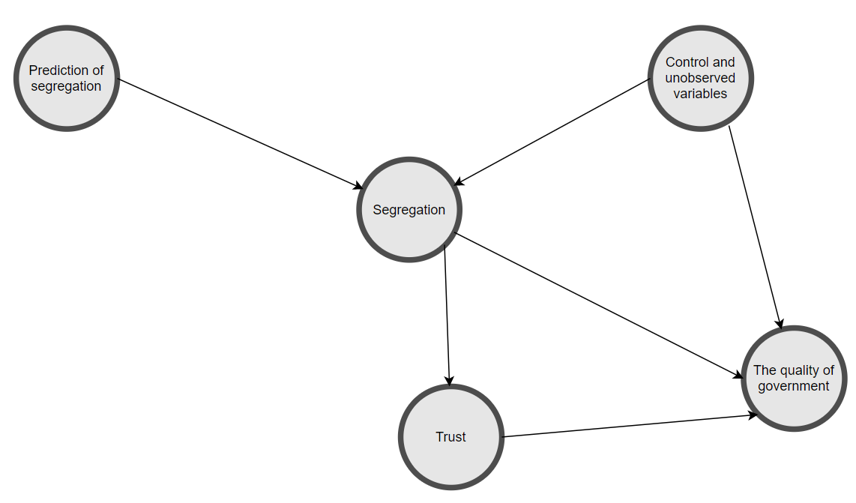

In [4]:
causal1 = Image.open("files/causal_graph.png")
causal1.resize((int(3*causal1.width / 4), int(3*causal1.height / 4)))

## 4. Replication

---

In this chapter, I try to attempt to show the cores of Alesina and Zhuravskaya (2011) by following their empirical tests. To understand this procedure more clearly, I will include visualized figures. Moreover, in order to differentiate what is extension, the titles will be displayed as Extension 1, Extension 2, etc. The main steps are running OLS and 2SLS regression for causal relation and identifying feasible channels between segregation and governmental quality.
The key variables are segregation level of ethnicity, language, and religion. Extension 1 entails histograms where segregation levels are mainly distributed less than 0.1. More countries are distributed at the lower level of segregation. Additionally, it is identified that religion is less segregated compared to two other dimensions.

##### Extension 1 - Distributions of each segregation level

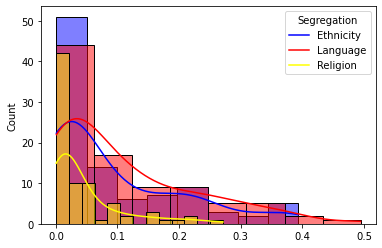

In [5]:
ext1(df)

### 4.1. Correlation in segregation
---

At the very outset, before evaluating how segregation influences the quality of government, the first thing to do is to describe how the indices are correlated to other factors in the dataset. The correlation between the two indices is significantly high and it can be demonstrated with scatter plots. Figure 1 includes the scatter plots of both theoretically correct and approximate segregation indices (i.e., $\hat{S}$ and $\tilde{S}$) for each of the three dimensions. It arguably shows the two indices are highly correlated since the approximate segregation only drops the "others" group.

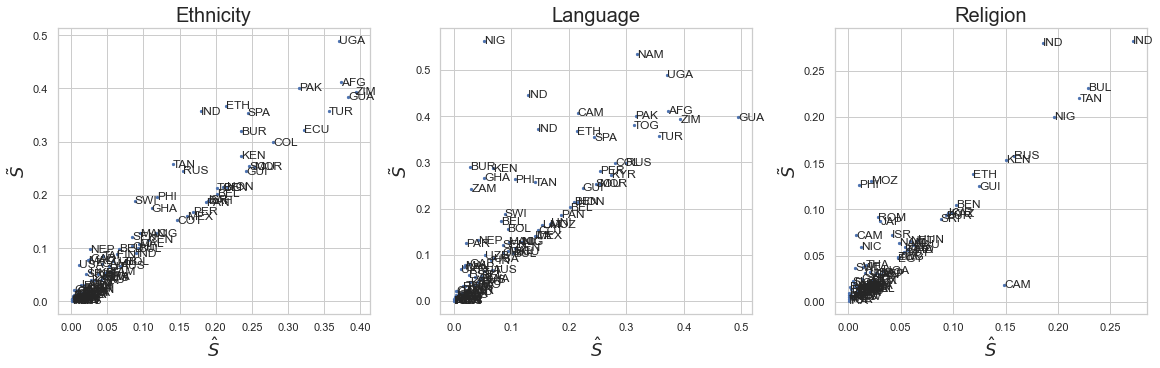

In [6]:
fig1(df_fig)

One would already anticipate that correlation of the segregation indices between ethnicity and language is high. One could further presume that people of one particular ethnic group potentially share the same language in a country. There is actually a highly correlated state here as can be perceived on the scatter plots of Figure 2 (which shows the correlation between one another in three dimensions). Furthermore, 46 countries do not have any distinction without a difference in ethnicity and language. People in these countries are separated as ethnic groups based on language differences. The correlation between segregation of religion and language or ethnicity is considerably lower.

##### Figure 2 - Segregation indices along the three dimensions of diversity

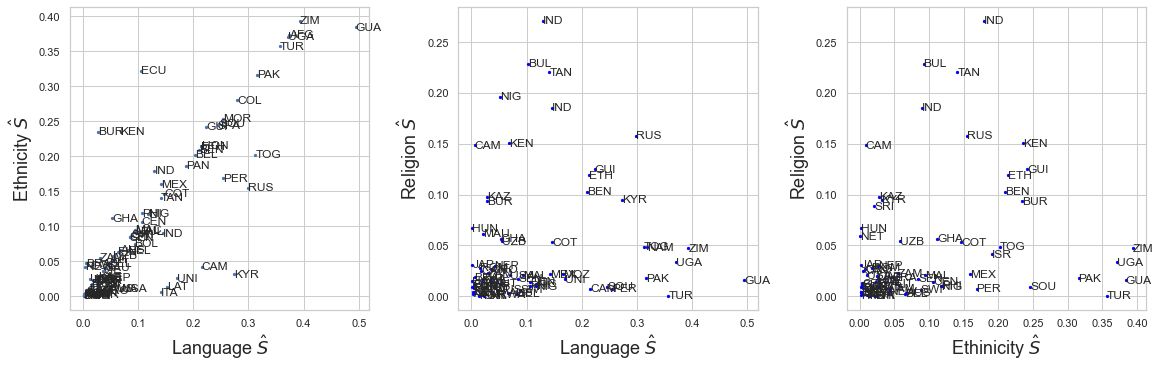

In [7]:
fig2(df_fig)

The correlation coefficients between each variable mentioned above are provided here.

##### Extension 2 - Correlation table

<AxesSubplot:>

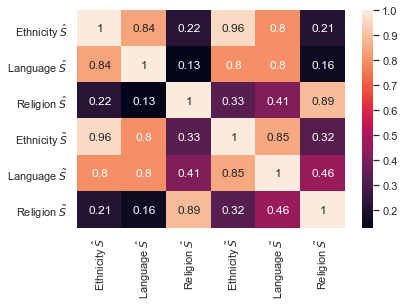

In [8]:
df_cor = df[['ethnicity_C2','language_C2','religion_C2','ethnicity_C','language_C','religion_C']]
df_cor.columns = ['Ethnicity $\hat{S}$','Language $\hat{S}$','Religion $\hat{S}$',
                  'Ethnicity $\\tilde{S}$','Language $\\tilde{S}$', 'Religion $\\tilde{S}$']
corr = df_cor.corr()
sns.heatmap(corr, annot = True)

plt.show()

The left column of Figure 3 shows that the segregation indices are correlated with the indices of fractionalization indices in both ethnicity and language aside from religion. The right column of this figure allows us to recognize the most important relationship between the segregation indices and the pace of development across countries. Alesina and Zhuravskaya (2011) establish as Slovenia the standard to distinguish between developed and developing countries. The mean value of segregation indices is shown below. The difference of segregation indices between two categories of countries is more than double in ethnicity and religion.

**Mean value**

|                  | **Above Slovenia**   | **Below Slovenia**    |
|-------------------|-------------------------|------------------------|
| Ethnicity  $\hat{S}$       | 0.11                    | 0.04                   |
| Language   $\hat{S}$       | 0.12                    | 0.07                   |                         
| Religon    $\hat{S}$       | 0.05                    | 0.02                   |

Spain, Belgium, and Israel are highly segregated by ethnicity in developed countries but none of them are ranked in the ten most segregated countries. These countries are possibly considered to have experienced ethnic conflicts. The Netherlands, Japan, and Israel are depicted as the most religiously segregated and their rank are below 17. One would interpret that the level in GDP per capita is positively influenced by the effort and factors to decrease segregation in countries. To analyze the correlation of segregation for each continent, the authors control for log of GDP per capita and fractionalization and hereby discover that Latin American countries are the most segregated on average. Asia and Africa do not maintain large differences. In addition, nontransition countries are generally more segregated than transition countries.

##### Figure 3 - Segregation and fractionalization (left); Segregation and log per capita GDP (right) 

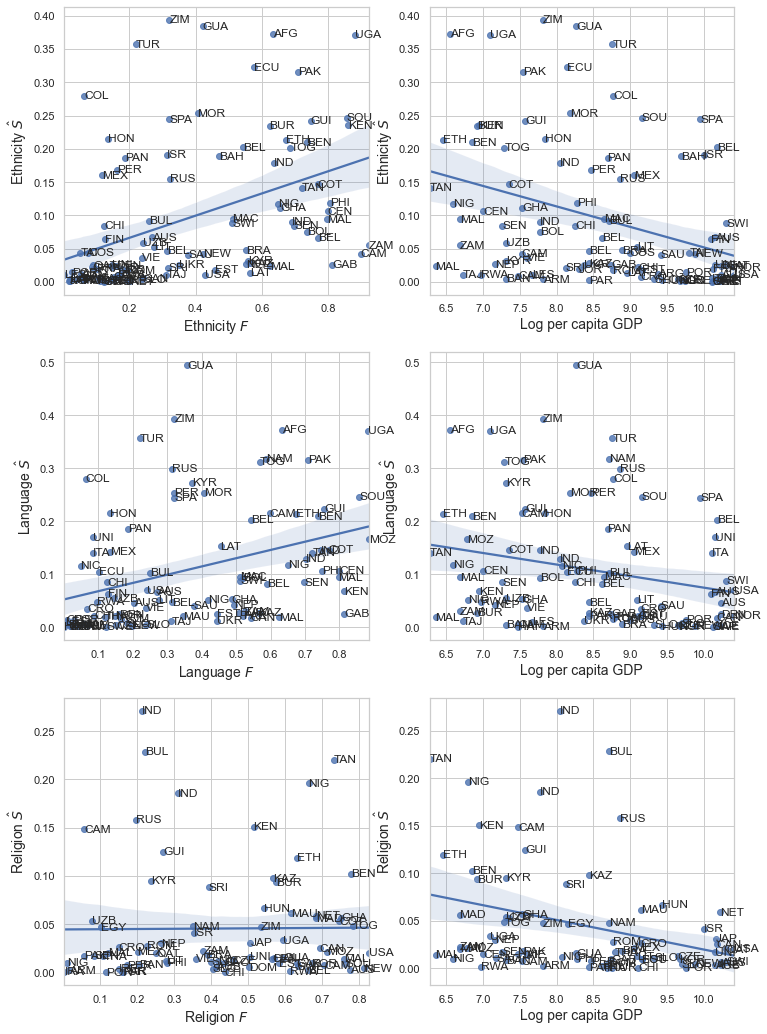

In [9]:
fig3(df_fig)

The tables demonstrated above present the correlation between segregation and per capita GDP without separating a categorization of countries. However, the democratic degree would also be an important factor to determine GDP and segregation level. This raises the question of which differences would occur if countries were categorized according to the level of democracy. All graphs of Extension 3 show that more democratic countries would be more influenced by segregation for development than less democratic countries. It will be more discussed regarding missing data and sampling in chapter 4. This arguably demonstrates that the evidence why the democratic level should be added as a control variable when regressing governmental quality.

##### Extension 3 - Segregation and per capita GDP by democracy level

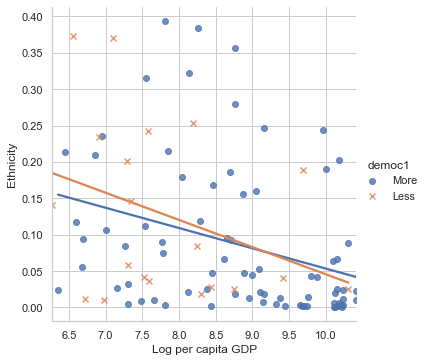

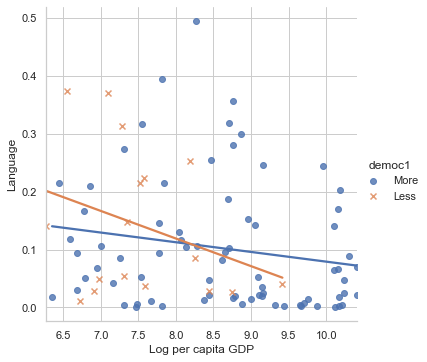

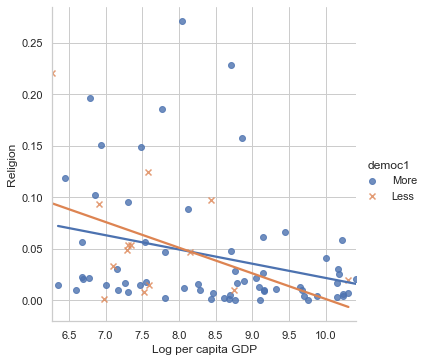

In [10]:
ext3(df)

Table 1 shows the most and least segregated countries by thier segregation indices of three categories.

##### Table 1 - The most and the least segregated countries

In [11]:
create_table1(df)

Ethinicity                                                     \
  Most segregated                  Least segregated                    
          Country $\hat{S}$    $F$          Country $\hat{S}$    $F$   
0        zimbabwe     0.394  0.320          germany     0.001  0.122   
1       guatemala     0.384  0.421           sweden     0.001  0.123   
2     afghanistan     0.373  0.634      netherlands     0.001  0.202   
3          uganda     0.371  0.883            korea     0.002  0.019   
4          turkey     0.357  0.220            japan     0.002  0.018   

         Language                                                     \
  Most segregated                  Least segregated                    
          Country $\hat{S}$    $F$          Country $\hat{S}$    $F$   
0       guatemala     0.495  0.358            haiti     0.001  0.001   
1        zimbabwe     0.394  0.320           sweden     0.001  0.123   
2     afghanistan     0.373  0.634            korea     0.002  0.019   
3          uganda     0.371  0.883          hungary     0.002  0.029   
4          turkey     0.357  0.220            japan     0.002  0.018   

         Religion                                                     
  Most segregated                  Least segregated                   
          Country $\hat{S}$    $F$          Country $\hat{S}$    $F$  
0       indonesia     0.271  0.215            chile     0.000  0.437  
1        bulgaria     0.229  0.223         portugal     0.000  0.117  
2        tanzania     0.220  0.732           turkey     0.001  0.159  
3         nigeria     0.196  0.663             iran     0.001  0.005  
4           india     0.186  0.311         paraguay     0.001  0.164

### 4.2. Correlation: Segregation and Governance
---

From now onwards, let us examine the correlation between segregation and standard measures of the quality of government will be examined by introducing six of the World Bank's Governance Indicators:

1. Voice
2. Political Stability
3. Government effectiveness
4. Regulatory quality
5. Rule of law
6. Control of corruption.

'Voice' is an indicator to evaluate whether citizens in a country are easily capable of participating not only in voting to choose their respective government but also in openly expressing freedom through independent media outlets. 'Political stability' captures the likelihood of political destruction. 'Government effectiveness' measures the quality of public services, independence from political pressures, and whether the policies are trustworthy. Regulatory quality indicates perceptions of the government ability to launch reasonable regulations that permit and promote private sector development. Rule of law represents the extent where agents in a country can safely activate their business and work without the crime and violence under the law. Finally, 'Control of corruption' entails the extent of public power controlling both small and large sizes of corruption. More detailed information and sources are available at [here](http://info.worldbank.org/governance/wgi/).

The entire correlation between the indicators is at least greater than or equal to 0.77. Table 2 illustrates that the pairwise correlation coefficients between the six indicators for the governmental quality and six segregation indices ($\hat{S}$ and $\tilde{S}$ for ethnicity, language, and religion). All coefficients of correlation are shown as negative and remarkably high. Arguably, the more intensified segregation is an impactful factor to lower the governmental quality. Some coefficients are higher than 0.5 in absolute value but this is not too outstanding when it comes to the situation where the governmental quality is firmly fastened with the level of development and fractionalization. Here, this is particular to the correlation between Political stability and the segregation index of ethnicity which is -0.55. The developed countries are not segregated in ethnicity as mentioned above and usually have a stable government. That is, the absolute value of the coefficient is fairly high.  

##### Table 2 - Pair-wise correlations and the quality of government

In [12]:
create_table2(df)

Segregation indicies                     \
                          Ethnicity $\hat{S}$ Language $\hat{S}$   
Voice                                   -0.36              -0.30   
PolStab                                 -0.55              -0.45   
Government effectiveness                -0.35              -0.24   
Regulatory quality                      -0.34              -0.24   
Rule fo law                             -0.40              -0.30   
Control of corruption                   -0.36              -0.27   

                                                                   \
                         Religion $\hat{S}$ Ethnicity $\tilde{S}$   
Voice                                 -0.25                 -0.37   
PolStab                               -0.33                 -0.56   
Government effectiveness              -0.27                 -0.35   
Regulatory quality                    -0.26                 -0.35   
Rule fo law                           -0.29                 -0.40   
Control of corruption                 -0.31                 -0.37   

                                                                    
                         Language $\tilde{S}$ Religion $\tilde{S}$  
Voice                                   -0.36                -0.19  
PolStab                                 -0.54                -0.30  
Government effectiveness                -0.32                -0.23  
Regulatory quality                      -0.32                -0.23  
Rule fo law                             -0.38                -0.25  
Control of corruption                   -0.36                -0.27

We cannot assure that the more serious segregation level has a negative impact on governance only with the correlation coefficients. Hence, our next interest is to identify whether the segregation level is linked to governance even by controlling for other variables including fractionalization and the level of development. Simple OLS regressions are run by the following form:

\begin{equation}
    Q_{i} = \alpha + \beta S_{i} + \gamma F_{i} + \delta' \mathbf{X}_{i} + \epsilon_{i}
\end{equation}

where $i$ indexes countries, $Q$ stands for a governance indicator; S and F are segregation and fractionalization indices, respectively; $\mathbf{X}$ is a vector of additional covariates, and $\epsilon$ is a heteroskedastic error. Extension 4 contains regression plots between rule of law and ethnic segregation controlling for all variables which will be explained below. Heteroskedastic error is identified through the top right graph, residual plot.

##### Extension 4 - Regression plots between ethnic segregation and the rule of law with all controls

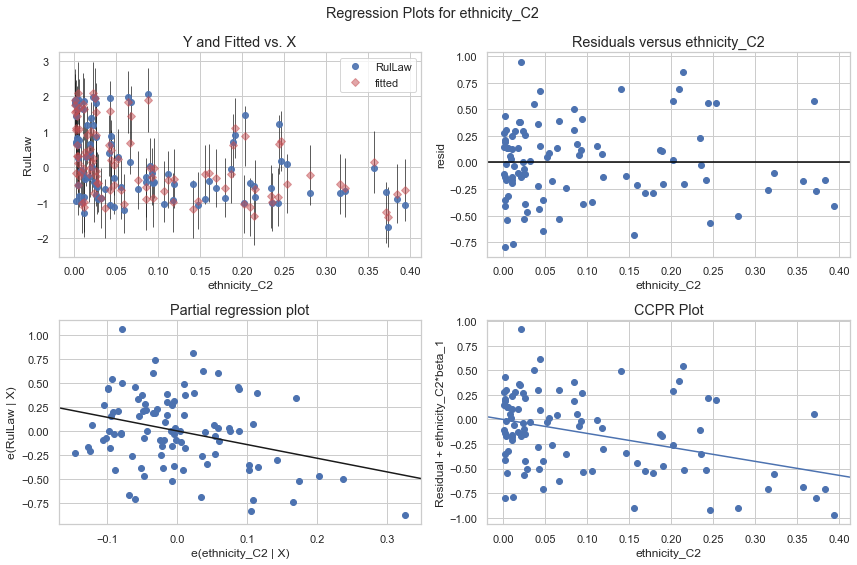

In [13]:
# ethnicity_C2 is ethnic segregation (Ethnicity S_{hat})
ext4(df_E)

 The regressions will be running three times for each dimension of ethnicity, language, and religion. Table 3 describes regression results with the dependent variable, rule of law. Columns 1, 3, and 5 on Table 3 only contain segregation and fractionalization indices. All segregation on those columns meaningfully has negative effects for the governance at least in the 10 percent confidence interval. The fractionalization index also negatively influences ethnicity and language but positively influences religion. The reason why only linguistic fractionalization has a positive effect is the homogeneous affiliation of citizens for a religion is more likely to happen in a country that has a "bad" government. Many countries limit religious freedom, or it is not existed by law.

Other covariates are added on columns 2,4 and 6. The most important one of them is log of GDP per capita because the development degree and government quality of a country are closely correlated with the per capita income. Alesina and Zhuravskaya (2011) also make the regression conditional on log of population size since this can directly influence the governmental quality. Especially, the larger the population size is, the harder it would be for the government to effectively implement its policies. They additionally control for the democratic tradition and two geographical variables: latitude (a common control for adverse climate conditions) and a measure of the extent where a country is covered by mountains. This measure of mountain coverage is added to the list because segregation would rely on the physical separation due to the fact that mobility, as well as government policies, may influence citizens less effectively. They also add legal origin dummies as inspired by La Porta et al. (1999).

The valuable factor is that ethnic and linguistic segregation indices are negatively influential for the rule of law at the 5 percent level by controlling for other variables. However, religious segregation does not carry any further value to this model. Additionally, fractionalization indices of three dimensions are deprived of significance, unlike the previous model that does not uncontrol for other variables. Any variable aside from GDP per capita and democratic tradition is not considered statistically significant.

##### Table 3 - Segregation and the rule of law, OLS regressions

In [14]:
table3_7(df,'OLS')

You can find which country is without dictatorships or others on Extension 5. Gray areas represent missing values. It is to be borne in mind that this data is based on the past, and, thus the current world map that would be altered.

##### Extension 5 - World map according to the degree of democratization

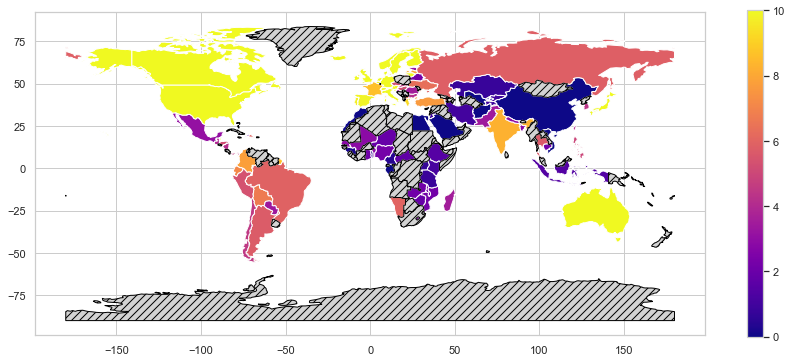

In [15]:
ext5(df_w,world)

In Tables 4 and 5, I run OLS regression for the six indicators of governance concerning ethnic and linguistic segregation. These tables report contracted results by separating three panels. Panel A presents the result controlling for all variables. Panel B arises conditionally only to fractionalization and segregation with full sample and Panel C only considers countries where the evidence of dictatorships cannot be found. The definition of the subset of countries that excludes dictatorships is countries with an average Polity IV democracy score less than one for the years 1975 - 2004. 

Ethnic and linguistic diversity come first for a more precise interpretation of Tables 4 and 5. On the one hand, fractionalization has a meaningfully negative effect on governance only in regressions without controlling for other variables. On the other hand, indices of ethnicity and language segregation are negatively connected with the indicators representing government quality in both situations where regressions do contain controls and do not. Ethnicity segregation is always a significant factor in regression without controls but language segregation has an exception that is for regulatory quality. The measure of ethnic segregation negatively affects voice, political stability, rule of law at least at a 10 percent significance level with all controls. As Extension 3 showed, different results can be expected on the regression only for the subset of democracies. On Panel C with categorizing a subset of democratic countries, the coefficients of both indices are more significant by lower p-values. The only insignificant coefficient is linguistic segregation for regulatory quality. In addition, the absolute value of the coefficients is greater compared to Panel A.

##### Table 4 - Ethnic segregation and the quality of government, OLS 

In [16]:
for i in range(3) :
    HTML(table4_5(df,'ethnicity')[i].render_html())

##### Table 5 - Linguistic segregation and the quality of government, OLS

In [17]:
for i in range(3) :
    HTML(table4_5(df,'language')[i].render_html())

### 4.3. Causal inference
---

As briefly mentioned above, segregation relies on the geographical distribution of people. Choosing the place where people live is endogenous to political and economic issues. There are examples from huge events including civil wars, revolutions, or invasions to small events such as local taxation system or public goods (Tiebout 1956). For example, citizens in developing countries readily experience harsh transportation systems. Moreover, when specific segregation groups cannot even expect basic infrastructure due to the low quality of government, they would construct their own geographical community to make the situation better by living closer. It produces a reverse causality from the governmental quality to segregation.

#### 4.3.1. Derivation of instrument

The first thing to consider is to remove the reverse causality. The idea for the instrument proposed by Alesina and Zhuravskaya (2011) is based on the spatial distribution of groups around neighboring countries since the government quality cannot affect groups dwelling in another country. They make a prediction about where a segregation group lives with an assumption that the group geographically attracts people belonging to it. Let us imagine that there are two countries sharing borders. Additionally, a segregation group in one home country exists around the borders of the neighboring country. People of the group in the home country would be more likely to move to the area around the group in which they belong. Here are two cases.

1. If there were groups around the area in the home country, this country would be more segregated.
2. Otherwise, this country would have more uniformly distributed groups.

Figure 4 is helpful to build the fundamental concept of the instrument. Note that HC refers to home country. The basic assumption is that HC1 has four adjacent countries and totally homogeneous four segregation groups. The prediction for segregation of HC1 would be one owing to each separated area of all groups located near the same segregation group. In contrast, HC2 would have zero of the predicted segregation level. Any group of four in neighboring countries is not added to the community around HC2.

##### Figure 4 - Predicted location of groups

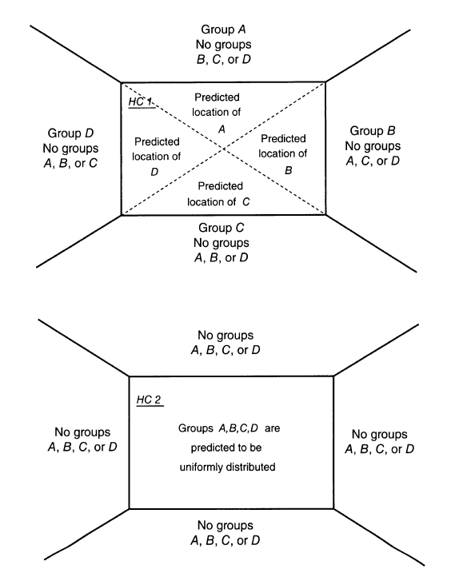

In [18]:
img1 = Image.open("files/Figure_4.png")
img1.resize((int(4*img1.width / 5), int(4*img1.height / 5)))

According to this idea, the predicted distribution is derived through several steps. The authors concentrate on matching all major groups (where the group size is greater than or equal to 10 percent of the country's population) of the neighboring countries to each group of the home country so as to reduce a labor-intensive process. A violating case for our IV assumption would be cross-border migrations from neighboring countries to the home country because of the governmental quality. However, it is such a rare case and thus not negligible in this context. The predicted distribution is calculated as follows. Note that $t_{mk}$ is the number of people from a group $m$ which is located in the hypothetical area $k$ of the home country. When there are no neighboring countries that locate group $m$ as a major group, people from a group $m$ are uniformly distributed in the home country. Formally,

\begin{equation}
    t_{mk} = \pi^{HC}_{m} T^{HC} \frac{1}{K}
\end{equation}

where  $\pi^{HC}_{m}$ is the fraction of group $m$ in the home country, $T^{HC}$ is the total population of the home country. $K$ represents the number of neighboring countries, namely, hypothetical regions. On the contrary, if at least one neighboring country has group $m$ as a major group, the formula should be following distribution:

\begin{equation}
    t_{mk} = \pi^{HC}_{m} T^{HC} \frac{\pi^{k}_{m}}{\sum^{J}_{j=1} \pi^{j}_{m}}
\end{equation}

where $\pi^{k}_{m}$ is the fraction of group $m$ in the neighboring country that is adjacent to the region $k$. ${\pi^{k}_{m}}$/${\sum^{J}_{j=1} \pi^{j}_{m}}$ plays a role of gravitation to pull people into the region. For example, if only one neighboring country has group $m$ as a major group, people of the group $m$ in the home country are more possibly reside in the region sharing borders with the country.

Alesina Zhuravskaya (2011) create hypothetical regions F, G, A, and I in Switzerland and ignore Liechtenstein due to its too small population size. Germany only has Protestants as a major group around Switzerland, hence the predicted distribution is that all protestants are hypothetically located in region G. Catholic is a major group in all countries around Switzerland, namely in, France, Austria, Italy, and Germany. That is why, Catholics are distributed in all regions, F, G, A, and I. The rest of the major groups, the non-religious population, follow the same idea. The authors assume that minority groups are uniformly distributed through four regions.

Even though it is a well-fitted instrument to estimate the segregation of a country, an undesirable property is given. Suppose that a country has a fairly small and uniform region and there is a tiny group $s$ of the home country which is matched to a major group of a neighboring country $k$. Furthermore, any group aside from $s$ is not matched with the major group of the country $k$. As a result, the segregation index is very high since $s$ is the only group in the hypothetical region $k$. However, in the real world, regions are too large for a tiny group to make them homogeneous with a high segregation level. The authors deal with this situation by setting a lower bound to the population size of hypothetical regions. Note that the authors suppose that all countries that have no and only one neighbor has uniform distribution of groups.

##### Figure 5 - Predicted location of religious groups across hypothetical regions in Switzerland

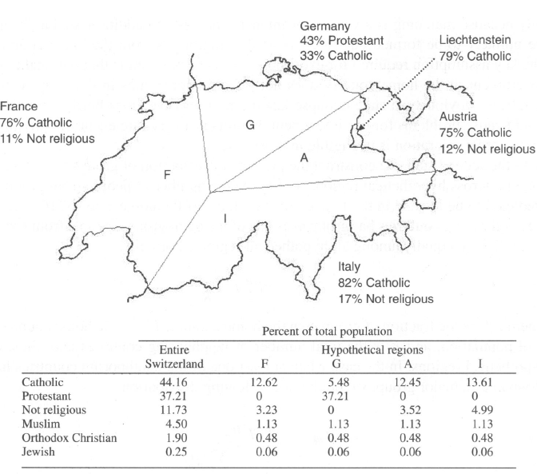

In [19]:
img2 = Image.open("files/Figure_5.png")
img2.resize((int(4*img2.width / 5), int(4*img2.height / 5)))

#### 4.3.2. Results of 2SLS regression

The instrument that we derive is established on accounts of whether it has sufficient predictive power for actual and approximate segregation. The first thing to do then is to run first stage regression controlling for all covariates. It follows this formula:

\begin{equation}
    S_{i} = \alpha + \beta S^{p}_{i} + \gamma F_{i} + \delta' \mathbf{X}_{i} + \epsilon_{i}
\end{equation}

where $S^{p}_{i}$ is a measure of predicted segregation. Table 6 reports the results of the regression of this model by the first stage regression.
Panel A is the first stage for $\hat{S}$ and panel B for $\tilde{S}$. The right three columns of the panels have a full sample but the left three columns exclude the countries with dictatorships. The instrument has a strong prediction for actual segregation in both cases except for language for $\tilde{S}$. It appears to be stronger for $\hat{S}$ than $\tilde{S}$. Especially, approximate linguistic segregation does not appear to be predicted well enough by the instrument. The reason for that is due to an outlier, Since the United States has only two adjacent countries above and below it, it shares northern borders with Canada and southern borders with Mexico. Consequently, the linguistic segregation group for the English language is predicted to encompass the northern (Canadian) area while the group for the Spanish language is predicted to be in the southern area. This is why the US is the only nation with predicted linguistic segregation. In that sense, panel C reports the first stage for the linguistic $\tilde{S}$ except for the US. Arguably, the instrument is compelling and significant enough for approximate language segregation. This table proves that the instrument has sufficient prediction power for actual segregation and approximate segregation.

##### Table 6 - First stage: Segregation and predicted segregation

In [20]:
for i in range(3) :   
    HTML(table6(df)[i].render_html())

Let us then turn from extracting IV to applying the 2SLS regression with the IV. Table 7 provides the outcomes of the second stage regressions for $\hat{S}$ without any control aside from fractionalization and with all controls. The coefficient of segregation with all controls is significant except for religious diversity as perceivable in Table 3. This could be evidence to exclude segregation of religion as a key variable. GDP per capita and democratic tradition are still significant factors on this table. Hereby, higher ethnicity and linguistic segregation would be one of the reasons to diminish one indicator for the quality of government, the rule of law.

Note that there are small differences. One difference between my replication table to the authors' original is the way to deal with the heteroskedasticity of this model. When I apply for HC1 estimators for OLS regressions, they were the best fitted to original results. However, my 2SLS regressions are based on HC0 since the library that I used dose not support HC1 (However, OLS regressions were run with HC1). That is why the standard error and p-value are slightly different from the original yet the results are almost identical. Nevertheless, there is no difficulty in obtaining valuable insights into this study through the results that I produce. Additionally, I remove Scandinavian legal origin for the 2SLS regression of religion segregation due to the singular matrix issue. It does not influence the results of regression. I argue that it has too small an estimator to be recognized so that the matrix is not considered as an invertible matrix.

##### Table 7 - Segregation and the rule of law, the second stage of the 2SLS regressions

In [21]:
table3_7(df,'IV2SLS')

There now are five more indicators that we ought to be identified in order to determine whether or not actual segregation is a proper explanatory variable for the governmental quality through using instrument. Tables 8 and 9 display the results of the second stage regressions for six indicators of governance. Table 8 especially presents ethnic segregation and also that all coefficients of segregation are negative. It bears differences in comparison to OLS regressions. Ethnic segregation is not a significant factor for 'voice' anymore but rather appears to be essential for other indicators. For the democratic sample, it is still meaningful for all governance. 

Table 9 reports the results about linguistic segregation. Panel A maintains the outcome about which dependent variables are carefully explained in table 5. Simultaneously, the results of panel A are also significant for three indicators (Voice, political stability, and rule of law) in spite of different p-values. Linguistic segregation becomes a significant factor for all governance indicators with sampling democratic nations.

One tangible insight from these tables could be yielded from the differences between the sampling democracy subset and not sampling democracy subset. In the case of sampling, coefficients of the segregation become more meaningful with lower standard error or they even fluctuate to become significant despite being insignificant under the full sample situation. However, GDP per capita and democratic circumstances are always fundamental factors. Nations under dictatorships would be outliers such that their indicators of governmental quality are more influenced by the dictatorship itself rather than the segregation situation.

##### Table 8 - Ethnic segregation and the quality of government, the second stage of 2SLS

In [22]:
for i in range(3) :  
    HTML(table8_9_ext7(df,'ethnicity','democ')[i].render_html())

##### Table 9 - Linguistic segregation and the quality of government, the second stage of 2SLS

In [23]:
for i in range(3) :   
    HTML(table8_9_ext7(df,'language','democ')[i].render_html())

### 4.4. Alternative measures of the quality of government
---

The dependent variables, the World Bank's Governance Indicators have been most commonly utilized to evaluate the quality of government in research. However, there are other additional indices that can be used as a reasonable measure to representing governmental quality. The segregation that is proper key variables for the governmental quality can be more stably and structurally assured by running regressions for new indicators of the government quality. Here, Alesina and Zhuravskaya (2011) introduce six new indicators. I hereby drop the Corruption Perception Index due to the missing values. To make it clear, ICRG quality of gov. combines "corruption", "law and order" and "bureaucracy quality". EF Property rights is self-explanatory whereas. EF Corruption represents freedom from the corruption index and Tax Eva presents the tax compliance index. EF Regulation is noted as a business regulation index.

These new indicators can be shown as trustworthy alternative indices by identifying the high correlation between the new indicators and the World Bank's Governance indicators. The correlation between them is also high. Tables 10 and 11 basically follow the same structure of table 4, 5, 8, and 9 except for regression for All controls and full sample (e.g Panel A of table 8 and 9). Columns with odd numbers present the regression result with OLS and even-numbered columns for 2SLS regression. For OLS regressions, ethnic segregation has significantly negative effects on the alternatives except for the regulation index and for Tax evasion index under the democratic sample. Through 2SLS regression, it is also negatively significant except for Tax evasion index. The results of linguistic segregation are analogous to one of ethnic segregation but they are weaker in 2SLS regressions. The causal effects of 2SLS regression are only significant for the Corruption index and Property rights index in the sample excluding dictatorships. 

In short, the causality effect of segregation on government quality would become diverse according to the sphere of government quality. However, segregation indices still play an essential role in explaining both dimensions of the quality of government. Additionally, the tax evasion index is not affected by the segregation both for the democratic and autocratic governments.

##### Table 10 -  Ethnic segregation and alternative measures of government quality

In [24]:
table10_11(df,'ethnicity','non')
table10_11(df,'ethnicity','democracy')

##### Table 11 -  Linguistic segregation and alternative measures of government quality

In [25]:
table10_11(df,'language','non')
table10_11(df,'language','democracy')

### 4.5. Mechanisms
---

Finally, let us investigate which factor is an actual channel for the causality effect from segregation to government quality. The authors suggest three feasible channels of how segregation influences government quality: trust, secession threats, and ethnic voting. Trust has been considered one of the most important social capital to estimate governmental quality. La Porta et al. (1997) discovered that a government is less effective in a country where there are low degrees of trust among citizens. The secession of threats plays a role to distract the abilities of the government so as to invest in valuable public goods for economic growth. This is because they concentrate on creating more attractable appeasement or repression for a segregation group that wants to separate from the central government. Ethnic voting would cause a problem in decreasing the quality of government. A group would vote for ethnically identical candidates regardless of their election pledges and qualities.

They measure trust by utilizing the standard "generalized trust" question from the World Values Survey (WVS), namely: _"Generally speaking, would you say that most people can be trusted or that you cannot be too careful in dealing with people?"_ They obtain the mean value of positive answer percentage in each country, i.e., _"Most people can be trusted,"_ across all available waves of WVS so as to evaluate the trust. Table 12 reports the results of OLS regression on the left three columns and 2SLS regression on the right three columns for trust. Columns 1 and 4 bear the results with full sample and without control. Outcomes with full samples and controls can be found in columns 2 and 4. Columns 5 and 6 are based on the sampling that excludes dictatorships and controls. All coefficients of language are significantly negative on regressions for the level of trust in a country. Additionally, only column 3 of ethnicity reports the coefficient is statistically insignificant. These results are enough robust to consider it potential channel of segregation to influence the government indicators.

To measure secession of threats, Alesina and Zhuravskaya (2011) import a dummy variable that shows whether any ethnic group had attempted to be independently separated from their home country with actual autonomy movement. They try to examine the relationship between the secession of threats and segregation level but there are no solid results between them.

They use a dummy variable to measure the ethnic voting in a country. The dummy indicates if, there is an ethnic party in any country that has a nontrivial share of the vote in the last legislative elections. Ethnic party is established as it 
>_" appeals to voters as the champion of the interests of one ethnic category or set of categories to the exclusion of others, and makes such an appeal central to its mobilizing strategy. The key aspect of this definition is exclusion. An ethnic party may champion the interests of more than one ethnic category, but only by identifying the common ethnic enemy to be excluded"_ (Chandra 2005, p. 236). 

The relationship between segregation and the existence of ethnic parties in a country is significantly positive in all cases. Note that you can find the results of regressions for secession of threats and ethnic voting on Table 9 of Alesina and Zhuravskaya (2011). Here, I only replicate the relationship between linguistic segregation and trust but additionally expand on the regression for trust with ethnic segregation. Trust is only considered the statistically feasible channel of them so that I focus on it.

##### Table 12 - Segregation and trust as a potential channel

In [26]:
df_table12(df,'ethnicity')
df_table12(df,'language')

As the last step, it remains to ensure that the potential channels are actually associated with the governmental quality. To qualify them as channels of influence, they should have significant coefficients in regressions for the governmental quality by controlling for measures of segregation. In addition, the results of regressions should present that the magnitude of the coefficient on segregation level decreases. Table 13 reports reduced outcomes of several regressions. Columns 1 and 4 control for no potential channels, columns 2 and 5 only for trust, and columns 3 and 6 control for all potential channels (trust, the ethnic party dummy, and the separatist movement dummy) as covariates. The right three columns are for OLS regression and the other columns for 2SLS regression.

Let us measure column 1 against 2 and 4 against 5. It is the difference between conditioning trust or not. This comparison emphasizes that the magnitude of coefficient on segregation makes huge differences on the regressions for governmental quality. The coefficients on segregation virtually decrease in absolute value. In many cases, including trust as a covariate make the coefficients insignificant. The coefficients on trust are always significantly positive in these models. It displays that trust plays a crucial role in passing the effect of segregation to the government quality. Columns 3 and 6 do not look like that the other two potential channels exert an influential power on the governmental quality. The coefficients from 2 to 3 and from 5 to 6 are technically not fluctuated further. When the regression model includes trust as a covariate, neither ethnic parties nor separate movement dummies are statistically valuable. Nevertheless, we cannot conclude that the two channels are implicitly negligible variables to infer the path of segregation. The first reason is that the variables are dummies so that they cannot contain diverse variations of each country but shows the existence and nonexistence of an occurrence. Secondly, the three channels are highly interdependent to each other. More ethnic voting and separatists would be stem from low trust among citizens. Consequently, we can barely analyze the independent effect of each variable on the quality of government.

##### Table 13 - Segregation and potential channels of influence

In [27]:
'Panel A. Ethinicity'
table13_ext11(df,'ethnicity','').round(3)
'Panel B. Language'
table13_ext11(df,'language','').round(3)

'Panel A. Ethinicity'

OLS / None  OLS / Trust  OLS / All  \
Dependent Var                                                            
Voice               Segregation         -4.015       -3.024     -3.093   
                    Standard Error       0.803        0.837      0.912   
                    p-value              0.000        0.000      0.001   
Political stability Segregation         -5.159       -4.186     -4.200   
                    Standard Error       0.873        0.823      0.919   
                    p-value              0.000        0.000      0.000   
Govern-t effectiv.  Segregation         -3.043       -1.303     -1.303   
                    Standard Error       0.988        0.860      1.037   
                    p-value              0.002        0.130      0.209   
Regul. quality      Segregation         -2.845       -1.831     -1.751   
                    Standard Error       1.097        1.080      1.261   
                    p-value              0.009        0.090      0.165   
Rule of law         Segregation         -3.534       -1.791     -1.834   
                    Standard Error       1.012        0.867      1.061   
                    p-value              0.000        0.039      0.084   
Control of corr     Segregation         -3.373       -1.381     -1.399   
                    Standard Error       1.025        0.904      1.130   
                    p-value              0.001        0.127      0.216   

                                    2SLS / None  2SLS / Trust  2SLS / All  
Dependent Var                                                              
Voice               Segregation          -3.914        -2.307      -2.738  
                    Standard Error        1.678         1.638       1.937  
                    p-value               0.023         0.165       0.163  
Political stability Segregation          -5.437        -3.910      -4.794  
                    Standard Error        1.653         1.605       1.845  
                    p-value               0.002         0.018       0.012  
Govern-t effectiv.  Segregation          -4.356        -1.734      -2.115  
                    Standard Error        2.238         1.882       2.267  
                    p-value               0.057         0.361       0.355  
Regul. quality      Segregation          -3.875        -2.383      -2.793  
                    Standard Error        1.723         1.657       1.989  
                    p-value               0.029         0.156       0.166  
Rule of law         Segregation          -4.050        -1.317      -1.704  
                    Standard Error        2.234         1.901       2.266  
                    p-value               0.075         0.492       0.456  
Control of corr     Segregation          -4.352        -1.279      -1.947  
                    Standard Error        2.567         2.179       2.593  
                    p-value               0.096         0.560       0.456

'Panel B. Language'

OLS / None  OLS / Trust  OLS / All  \
Dependent Var                                                            
Voice               Segregation         -3.785       -2.615     -2.597   
                    Standard Error       0.856        0.863      0.906   
                    p-value              0.000        0.002      0.004   
Political stability Segregation         -4.389       -3.237     -3.222   
                    Standard Error       0.939        0.849      0.882   
                    p-value              0.000        0.000      0.000   
Govern-t effectiv.  Segregation         -2.917       -0.859     -0.873   
                    Standard Error       1.108        0.990      1.044   
                    p-value              0.008        0.386      0.403   
Regul. quality      Segregation         -2.506       -1.331     -1.275   
                    Standard Error       1.148        1.159      1.250   
                    p-value              0.029        0.251      0.308   
Rule of law         Segregation         -3.362       -1.280     -1.306   
                    Standard Error       1.127        0.989      1.037   
                    p-value              0.003        0.196      0.208   
Control of corr     Segregation         -3.291       -0.937     -0.925   
                    Standard Error       1.193        1.035      1.094   
                    p-value              0.006        0.365      0.398   

                                    2SLS / None  2SLS / Trust  2SLS / All  
Dependent Var                                                              
Voice               Segregation          -3.327        -2.155      -2.131  
                    Standard Error        1.749         1.704       1.816  
                    p-value               0.063         0.212       0.247  
Political stability Segregation          -2.819        -1.531      -1.452  
                    Standard Error        1.860         1.854       1.951  
                    p-value               0.136         0.413       0.461  
Govern-t effectiv.  Segregation          -1.944         0.136       0.155  
                    Standard Error        2.312         1.972       2.111  
                    p-value               0.405         0.945       0.942  
Regul. quality      Segregation          -2.105        -0.936      -0.850  
                    Standard Error        1.800         1.766       1.886  
                    p-value               0.248         0.599       0.654  
Rule of law         Segregation          -1.727         0.456       0.497  
                    Standard Error        2.373         2.044       2.184  
                    p-value               0.470         0.824       0.821  
Control of corr     Segregation          -1.843         0.577       0.646  
                    Standard Error        2.649         2.262       2.406  
                    p-value               0.490         0.800       0.789

## 5. Extension with critical assessment

---

### 5.1. Missing data and sampling
---

There is inevitably missing data for several countries. The total number of the country on this dataset is 109 but the world has a lot more countries than this number (of course, there are too small countries to be contained). If the dataset randomly loosed the countries, it would not make a critical problem for the results. However, we could reasonably guess it is not likely to be random. The reason is that poorest countries would possibly not have the proper infrastructure to investigate information that this paper needs compared to other countries. If it were possible to construct a dataset that has more samples, we would produce more impressive results.

However, it is possible to research if the coefficient of segregation of the regression on the governmental quality is more negative among more democratic or richer countries. The distributions of segregation are right-skewed as above shown on Extension 1 and segregation level has a significant correlation with GDP per capita. My supposition is that this data includes more of the relatively rich countries with the above-shown tables. Moreover, this becomes more persuasive with the fact that the correlation coefficient between democratic degree and the wealth of nations should be assumed significantly high (it is shown Extension 8). 

I draw two plots to identify my assumptions and one of them is failed. Extension 6 reports the QQ plot of ln GDP per capita and democracy. The results are different from what I argued about the distribution of countries' GDP per capita in this data. The distribution has a weak feature of multimodal distribution but looks overall well-fitted to the normal distribution. On the contrary, following my assumption, the data of more democratic countries are collected rather than countries under dictatorships. The distribution of it is left-skewed.

##### Extension 6 - QQ plots of lnGDP per capita and democracy index

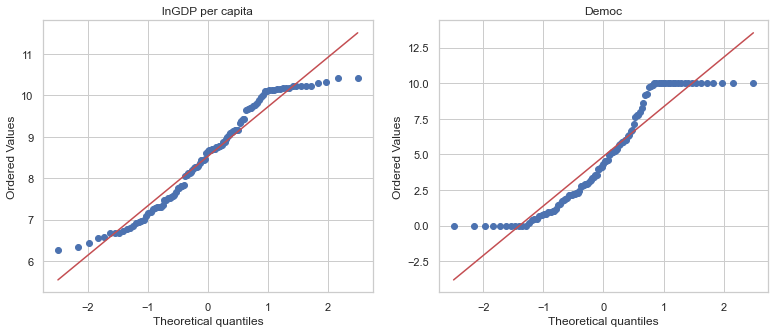

In [28]:
ext6(df)

Then, let us argue if the fact of biased data set for the dictatorships is influential to our main results. You might remember we separated two types of samples, one is for all samples and the other one is only for samples that exclude dictatorship. Each result of them is pretty diverse, namely, that the effect of segregation is more negative and significant in almost all cases both for ethnic and linguistic segregation. The unfortunate fact is that the analysis is not able to be progressed due to a lack of data about less democratic countries. About more democratic countries, the conclusion is that segregation would potentially have a more powerful impact on the quality of government.

How about GDP? Sampling a specific group about the wealth of the nation would also influence the results of regressions since it is comparably correlated to the democratic level. Thus, I run 2SLS regressions for the governmental quality on ethnic segregation by removing 12 countries in ethnicgroup and 14 countries in linguistic group reporting the lowest GDP per capita and, with full controls. Panel A of Extension 7 presents coefficients of ethnic segregation are rather lower compared to 2SLS regression with the full sample in all cases. In the case of control of corruption, ethnic segregation is not even significant. Panel B of Extension 7 is the regressions on linguistic segregation also constantly show the weaker effect of segregation. These results mean that the influence of segregation is consistently weaker in the wealthier countries. It does not support my expectation. Segregation would become a less important factor to decide the governance indicators among the sample that excludes countries with low GDP per capita. However, it is not sufficient to conclude that since there exist strongly positive correlation between per capita income and democratic level. The reason that I suggest is that omitted variables and measuring error would influence it. 

It is identified that the result with wealthier countries is at odds with one without samples excluding dictatorship in spite of higher correlation GDP per capita and democracy level. However, there is a remarkable insight that the effect of segregation level would become diverse according to the way of sampling such as removing autocratic states and countries with lower GDP per capita. There are restrictions that we cannot easily resolve to construct that analysis due to a lack of data. It is a limit to not being able to research more detailed effects on each country. However, if there is a way to fill up the data, it could be possible to derive better-fitted values to the population parameter for each circumstance. For example, more data about less democratic countries would make it possible to run a regression without highly democratic countries. The difference between two groups without either highly autocratic or democratic countries could be produced.

##### Extension 7 - Segregation and the quality of government with removing poorest countries

In [30]:
HTML(table8_9_ext7(df,'ethnicity','GDP').render_html())
HTML(table8_9_ext7(df,'language','GDP').render_html())

### 5.2. Multicollinearity test
---

Multicollinearity is one reason to block precise results in regression. It would occur when the relations of variables are not independent to each other. The authors have tried to more correctly produce coefficients of our key variables, namely, segregation indices, by comparing with and without controlling for other variables. Even though the ethnic and linguistic segregation were significantly and consistently negative in both situations, I hereby suggest to more precisely check the multicollinearity. The effect of multicollinearity between religious segregation and other variables would prevent it to be significant by raising standard error.

Religious segregation has not been considered a significant variable in analysis so far. However, serious religious conflicts in a country would considerably lead worse democratic situation since the government would make stronger and more coercive policies to stop conflicts. Moreover, as Figure 3 shows in chapter 4.1. there exists a correlation between segregation and GDP per capita. That is why I suggest the significance of segregation of religion would decrease by the multicollinearity issue. 

Other segregation would be also more significant than the reported results for several governance indicators. There is an instance of ethnic segregation. ethnic voting (i.e. a potential channel from segregation to the government quality) would make ethnicity and democracy correlated since ethnic segregation is highly associated with ethnic voting (See table 9 of the original paper). An elected member of Parliament would behave anti-democratic action such as getting an effort to legislate advantageous laws for their ethnicity rather than public. 

Six significant variables, religion and, additionally, trust are selected to present multicorrelation in Extension 8. The correlation between religion and GDP per capita and democracy are reported -0.31 and -0.25, respectively. It is not sufficient to say there should not be multicollinearity issues. The correlations coefficient between instrument and democracy as well as GDP per capita become lower than the results of segregation. It supports the instrument is valid.

##### Extension 8 - Multicorrelation among significant variables and trust.

<AxesSubplot:>

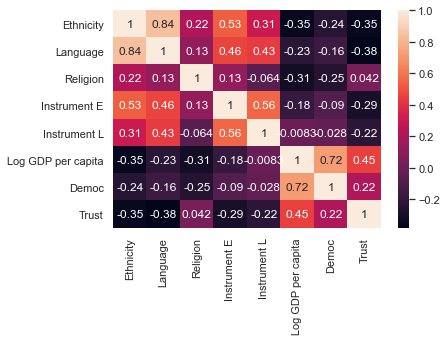

In [31]:
df_cor = df[['ethnicity_C2','language_C2','religion_C2','ethnicity_instrument_C2_thresh',
             'language_instrument_C2_thresh','lnGDP_pc','democ','trust']]
df_cor.columns = ['Ethnicity','Language','Religion','Instrument E','Instrument L','Log GDP per capita','Democ','Trust']
corr = df_cor.corr()
sns.heatmap(corr, annot = True)

plt.show()

To check it, let us identify the multicollinearity with the variance inflation factor (VIF). The greater VIF is, the larger standard errors regression has. The minimum value of 1 for VIF means the covariate is completely orthogonal to other covariates. The coefficients with greater VIF would be presented less significantly than they are. Extension 9 reports the VIF values of OLS and 2SLS for the rule of law as controlling for all variables. The VIF values of religious segregation in both regressions are pretty low which means perhaps there are no multicollinearity issues on them. This strongly supports that the results (especially standard errors) about segregation are not incorrect in a company with consistent results of both regressions with and without controls. Additionally, some other covariates have VIF values greater than 10 (the number to consider removing that variables by the rule of thumbs). However, they are not key covariates but controlled variables. That is, there is no reason to interest them. As a result, it can be concluded that religious segregation level is not a significant covariate with more robust evidence.

Note that the other two segregation indices also have low VIF values. In addition, three of them do not have high VIF values regressions for other indicators of the quality of government as dependent variables.

 ##### Extension 9 - VIF of OLS and 2SLS for the rule of law with ethnic segregation

In [37]:
# religion_C2 is segregation index of religion (Religion S_{hat}).
# Legal origin of Scandinavia is removed here because of singular matrix issue.

vif1 = vif_cal(df_R, 'RulLaw', '', 'religion_instrument_C2_thresh', 'OLS').set_index('Var')
vif2 = vif_cal(df_R, 'RulLaw', 'religion_C2', 'religion_instrument_C2_thresh', '2SLS').set_index('Var')
pd.concat([vif1,vif2], axis = 1)

,VIF/OLS,VIF/2SLS
Var,,
religion_C2,1.51,2.39
religion_I,1.90,7.14
lnpopulation,2.82,192.06
lnGDP_pc,3.38,91.98
protestants,2.04,2.72
muslims,2.84,3.33
catholics,2.33,3.27
latitude,4.85,12.03
LOEnglish,1.84,2.63


### 5.3. Difference of coefficients between OLS and 2SLS regression
---

Note that I used here __R__ for extension 10 instead of Python to utilizing other libraries but I failed to integrate my __R__ codes on this notebook. However, I upload my R code as Extension 10 for R.txt in files for reproducibility.

The difference of coefficients of ethnic segregation between OLS and 2SLS regression is discussed here. The authors insist that the coefficients of 2SLS are consistently more negative than the results of OLS. We could actually check the results by comparing coefficients for each indicator. This gives rise to a question of whether or not the coefficients significantly and more negatively influence the governmental quality in practice. Confidence intervals of each coefficient would be helpful to naively recognize it. Extension 10 reports each coefficient of ethnic segregation with 90 percent confidence intervals in the full sample and all controls.  You can find the regression method and each governmental quality indicators, which we have dealt with, as dependent variables on the left side, respectively. As the authors' saying, all coefficients of 2SLS are shown lower than one of OLS. Voice can be skipped since the coefficients are not significant in both regressions. Except for it, each coefficient of 2SLS regression looks more negative than one of OLS regression, respectively.

Can we then really say that the coefficient has a more negative effect on the governmental quality on 2SLS than OLS? One would say "no" with the hypothesis:

\begin{equation}
    H_{0} : \beta_{2SLS} = \beta_{OLS}
\end{equation}
\begin{equation}
    H_{A} : \beta_{2SLS} \ne \beta_{OLS}
\end{equation}

When it is assumed that the confidence intervals of 2SLS regression are true at the population level, all coefficients of OLS regression are on the intervals. Therefore, one accepts that they are the same. Nevertheless, there are several points to refute. The standard error of coefficients on 2SLS regression would be derived higher because the instrument cannot perfectly predict an estimator. It leads to making it easier to adopt the null hypothesis (the coefficients are the same) by narrowing down the area of rejection. Additionally, as we discussed in chapter 4, there should possibly be endogeneity issues between segregation level and the governmental quality on OLS regression, which leads the biased coefficients. The coefficients of 2SLS regressions would be closer to the population. We could identify the segregation to have more negative effects on the governmental quality in 2SLS regressions. As a result, I conclude the coefficients of segregation become significantly more negative in 2SLS than OLS regression.

##### Extension 10- Confidence intervals of each coefficient at 90 percent

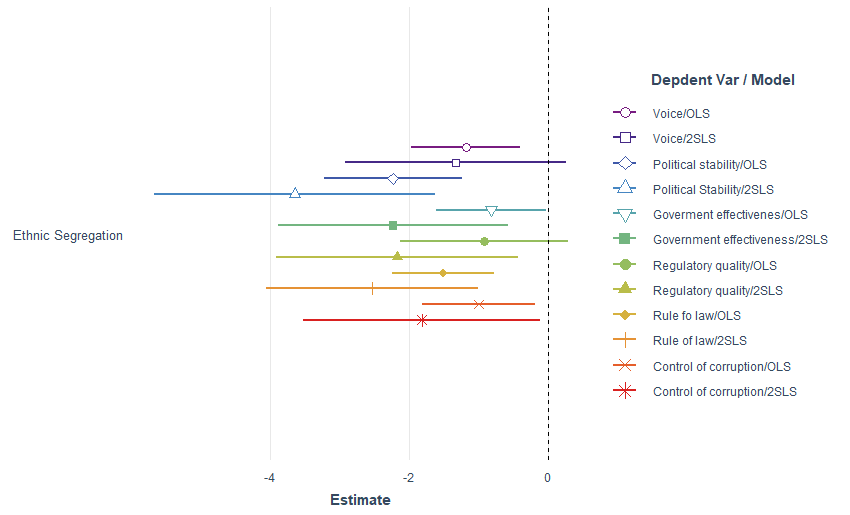

In [33]:
Image.open("files/Extension_10.png")

### 5.4. Robustness check for trust as a path
---

Trust is identified as a significant channel between segregation and government quality in the resutls of Alesina and Zhuravskaya (2011). How much trust affects the quality of government is questionable, though. Additionally, whether trust is an actual channel is also debatable. Extension 11 reports reduced results of trust on the same regressions of Table 13. They are all significant and positively affect the goverment's quality. Controlling for additional two feasible channels consistently makes no impressive difference to the coefficients of trust. However, the coefficients of trust are possibly not correct values it should have endogeneity issues with omitted variables of this regression.

##### Extension 11 - Trust for the governmental quality with ethnic segergation

In [34]:
table13_ext11(df,'ethnicity','trust').round(3)

OLS / Trust  OLS / All  2SLS / Trust  \
Dependent Var                                                              
Voice               Trust                 2.414      2.398         2.548   
                    Standard Error        0.592      0.573         0.649   
                    p-value               0.000      0.000         0.000   
Political stability Trust                 2.369      2.358         2.421   
                    Standard Error        0.682      0.638         0.636   
                    p-value               0.001      0.000         0.000   
Govern-t effectiv.  Trust                 4.238      4.236         4.158   
                    Standard Error        0.721      0.732         0.745   
                    p-value               0.000      0.000         0.000   
Regul. quality      Trust                 2.469      2.479         2.366   
                    Standard Error        0.573      0.567         0.656   
                    p-value               0.000      0.000         0.001   
Rule of law         Trust                 4.245      4.234         4.334   
                    Standard Error        0.761      0.765         0.753   
                    p-value               0.000      0.000         0.000   
Control of corr     Trust                 4.853      4.844         4.872   
                    Standard Error        0.879      0.863         0.863   
                    p-value               0.000      0.000         0.000   

                                    2SLS / All  
Dependent Var                                   
Voice               Trust                2.464  
                    Standard Error       0.676  
                    p-value              0.001  
Political stability Trust                2.248  
                    Standard Error       0.644  
                    p-value              0.001  
Govern-t effectiv.  Trust                4.086  
                    Standard Error       0.791  
                    p-value              0.000  
Regul. quality      Trust                2.286  
                    Standard Error       0.694  
                    p-value              0.002  
Rule of law         Trust                4.258  
                    Standard Error       0.791  
                    p-value              0.000  
Control of corr     Trust                4.743  
                    Standard Error       0.905  
                    p-value              0.000

We identified GDP per capita and democracy are significant factors in all cases. Additionally, the correlation coefficient between trust and GDP per capita and democracy is reported each 0.45 and 0.22 on Extension 8. However, Alesina and Zhuravskaya (2011) identified the results only from regressions without controlling for additional variables (i.e. GDP per capita and democracy). It would cause a problem of unbiased coefficient of trust in the regressions since the variables are considered omitted variables and make the endogeneity between trust and the government quality. That is why controlling for additional variables are needed to check robust results whether or not trust is a significant path. I suggest a new causal graph below.

##### Extension 12 -New causal graph

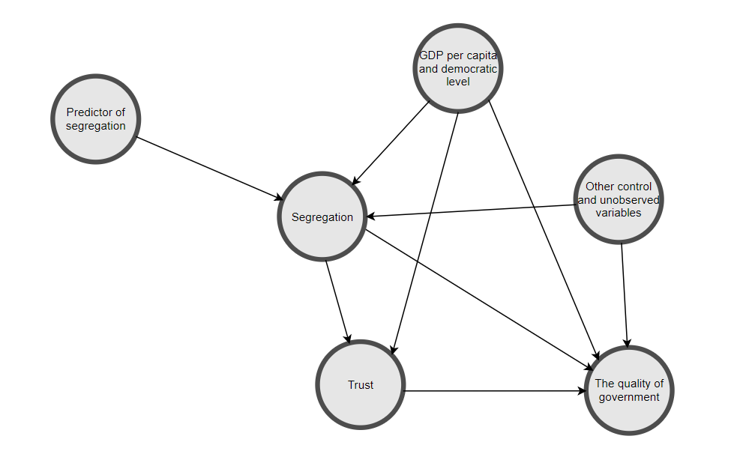

In [35]:
causal2 = Image.open("files/causal_graph2.png")
causal2.resize((int(3*causal2.width / 4), int(3*causal2.height / 4)))

I construct more exercises to verify the role of trust in this causal graph. Regressions (Table 13 and Extension 11) do not control for other variables, which we used in the previous analysis, to identify if segregation is significant or not, such as the economic and democratic situation of a country. These variables might influence trust and government indicators at the same time. The economic poverty of a country would make citizens disbelieve each other since they are engrossed to maintain their own livelihood. Moreover, regarding the democratic degree of a country, a dictatorship would break mutual trust among citizens by inspecting them and bury its own growth power with inefficient policies. So I ran multiple 2SLS regressions controlling for ethnic segregation and other variables to find out if trust is consistently significant for all indicators with all controls. The coefficients of trust are smaller compared to Extension 11, which means trust is a valid path as expected. However, trust is not significant for one indicator, regulatory quality.

The below table describes the outcome of regression for regulatory quality. Trust is not a significant factor in this table and the coefficient of segregation is even lower than the regression without trust. One would then say that trust is not an actual channel to convey the effect of segregation on the governmental quality. Unfortunately, it cannot be perfectly concluded that way since there would exist measurement error and omitted variables. Let us remind the definition of this indicator by World Bank: Perceptions of the governmental ability to launch reasonable regulations permitting and promoting private sector development. Aghion et al. (2010) produce several relationships between more serious distrust and stronger regulations to block competitive markets. The results of this paper are strikingly related to the definition of regulatory quality. Specifically, relationships with more trust among citizens in a country lead to better policies to stimulate the market economy. As a result, it is not ideal to exclude trust from the candidate that might convey the effect of segregation on regulatory quality despite the insignificant coefficient.
I have suggested some shreds of evidence so far to judge which insist is more reasonable but the decision is not that easy. If it is not a path between segregation and the quality of government, there should exist different feasible channels to explain the relationships between them. In a nutshell, despite the insistence of Alesina and Zhuravskaya (2011) that trust is always a feasible path to convey the effect of segregation level to governmental quality, my robustness check does not support it by producing one counterexample, the 2SLS regression table about regulatory quality.

In [36]:
df_t=df[['RegQual','ethnicity_C2','ethnicity_instrument_C2_thresh','ethnicity_I','lnpopulation','lnGDP_pc',
         'protestants','muslims','catholics','latitude','LOEnglish','LOGerman','LOSocialist',
         'LOScandin','democ','mtnall','trust']].dropna()

IV2SLS(df_t['RegQual'],df_t[['ethnicity_C2','ethnicity_I','lnpopulation','lnGDP_pc','protestants',
                             'muslims','catholics','latitude','LOEnglish','LOGerman','LOSocialist',
                             'LOScandin','democ','mtnall','trust']],
                      df_t[['ethnicity_instrument_C2_thresh','ethnicity_I','lnpopulation','lnGDP_pc','protestants',
                            'muslims','catholics','latitude','LOEnglish','LOGerman','LOSocialist',
                            'LOScandin','democ','mtnall','trust']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                RegQual   R-squared:                       0.822
Model:                         IV2SLS   Adj. R-squared:                  0.766
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Fri, 23 Jul 2021                                         
Time:                        20:35:30                                         
No. Observations:                  62                                         
Df Residuals:                      47                                         
Df Model:                          15                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
ethnicity_C2    -2.4626      1.437     -1.713      0.093      -5.355       0.429
ethnicity_I      0.1996      0.396      0.504      0.617      -0.597       0.996
lnpopulation    -0.1285      0.037     -3.461      0.001      -0.203      -0.054
lnGDP_pc         0.2659      0.088      3.023      0.004       0.089       0.443
protestants      0.0110      0.005      2.070      0.044       0.000       0.022
muslims          0.0017      0.003      0.527      0.601      -0.005       0.008
catholics        0.0029      0.003      1.138      0.261      -0.002       0.008
latitude        -0.8566      0.671     -1.276      0.208      -2.207       0.493
LOEnglish       -0.1451      0.199     -0.728      0.470      -0.546       0.256
LOGerman        -0.1902      0.286     -0.666      0.509      -0.765       0.385
LOSocialist     -0.3346      0.260     -1.288      0.204      -0.857       0.188
LOScandin       -0.9167      0.491     -1.865      0.068      -1.905       0.072
democ            0.0694      0.033      2.107      0.041       0.003       0.136
mtnall           0.0401      0.265      0.151      0.880      -0.493       0.573
trust            0.8634      0.682      1.266      0.212      -0.508       2.235
==============================================================================
Omnibus:                        9.834   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.879
Skew:                          -0.637   Prob(JB):                      0.00263
Kurtosis:                       4.725   Cond. No.                         736.
==============================================================================
"""

## 6. Conclusion
---

This notebook consistently replicates the results of Alesina and Zhuravskaya (2011). Overall, the authors manage to successfully demonstrate coherent results for their projected goals in their research. Through these respective goals, the authors display that ethnic and linguistic segregation (except for religion) negatively affects the governmental quality of a country. Simultaneously, this intends to capture the quality of government which is not influenced by fractionalization but rather by segregation. Moreover, Alesina and Zhuravskaya further delineate which channel is associated with the transmitter between segregation and the quality of government by comparing each coefficient of the two influential segregation levels. Their careful explanations aim to interpret the differences between segregation and fractionalization. Their provided dataset is additionally intended for further replication and extension of the results in their paper, which concurrently is one of the purposes of the authors. 

In relation to the authors' findings, my main purpose is to then run extensions that aim to critically illuminate and assess the legitimacy and reliability of the provided results in the authors’ research. This is why, throughout chapter 5 on Extensions. I identify the 2SLS regressions of Tables 8 and 9 that rarely have multicollinearity issues despite the noteworthy correlation coefficient. The difference of coefficients from OLS to 2SLS regression was also identified with statistical estimation. However, regarding potential channels, it is insufficient to insist that trust always transfers the effect of segregation to all governance indicators. Arguably,  trust would not be a medium between segregation and regulatory quality. Even if most results in the Extensions part support the authors' results, their results display several ambiguous points that can be perceived through critical assessment. This would be due to endogeneity, measurement error, and missing data. Despite this factor, it is still possible to confidently assume that the findings in this notebook strongly support the results of Alesina and Zhuravskaya. 

# 7. References

---

+ Alesina, Alberto, Arnaud Devleeschauwer, William Easterly, Sergio Kurlat, Romain Wacziarg. (2003). “Fractionalization.” Journal of Economic Growth 8: 155-94.

+ R La Porta, F Lopez-de-Silanes, A Shleifer, R Vishny. (1999). "The quality of government." The Journal of Law, Economics, and Organization, Volume 15, Issue 1, Pages 222–279.

+ Chandra, Kanchan. 2005. "Ethnic Parties and Democratic Stability." Perspectives on Politics, 3(2): 235-52.

+ Philippe Aghion, Yann Algan, Pierre Cahuc, Andrei Shleifer. (2010). "Regulation and Distrust." The Quarterly Journal of Economics, Volume 125, Issue 3, Pages 1015–1049.
